Import Necessary Libraries

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip drive/MyDrive/MangoLeafBD.zip> /dev/null
!unzip drive/MyDrive/Test.zip> /dev/null

In [8]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

Configuration

In [9]:
batch_size = 32
img_height = 180
img_width = 180
EPOCHS = 60

Datasets

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "MangoLeafBD",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "MangoLeafBD",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 800 files for validation.


Labels

In [12]:
class_names = train_ds.class_names
print(class_names)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


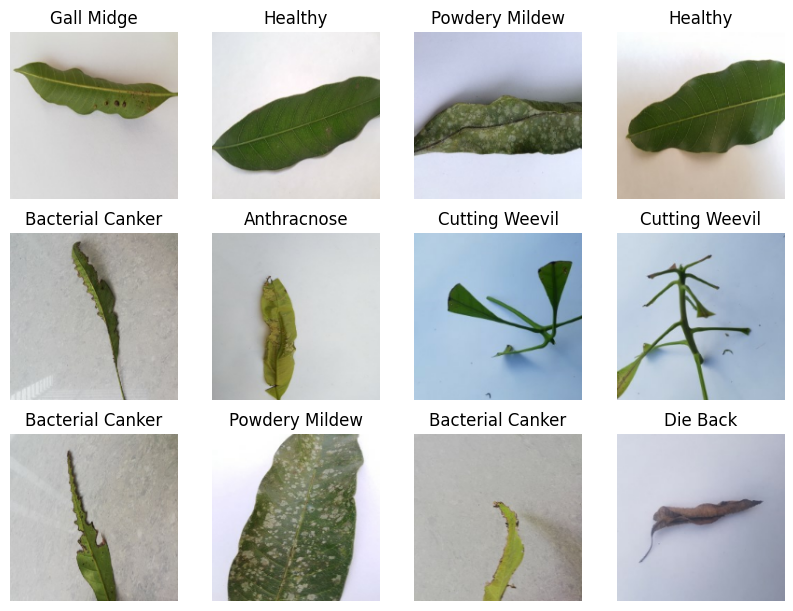

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Modeling the data

In [15]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax')
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                    

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
rlr = ReduceLROnPlateau(patience=10, verbose=1)
mc = ModelCheckpoint('model_mango.h5', save_best_only=True, verbose=1)

In [ ]:
epochs = EPOCHS
history = model.fit(
  train_ds,
  callbacks=[rlr, mc],
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
100/100 [==============================] - ETA: 0s - loss: 2.1292 - accuracy: 0.1941
Epoch 1: val_loss improved from inf to 1.72668, saving model to model_mango.h5
100/100 [==============================] - 24s 112ms/step - loss: 2.1292 - accuracy: 0.1941 - val_loss: 1.7267 - val_accuracy: 0.3587 - lr: 0.0010
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 1.4486 - accuracy: 0.4203
Epoch 2: val_loss improved from 1.72668 to 1.40518, saving model to model_mango.h5
100/100 [==============================] - 11s 106ms/step - loss: 1.4486 - accuracy: 0.4203 - val_loss: 1.4052 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 1.1381 - accuracy: 0.5537
Epoch 3: val_loss improved from 1.40518 to 0.98297, saving model to model_mango.h5
100/100 [==============================] - 11s 108ms/step - loss: 1.1381 - accuracy: 0.5537 - val_loss: 0.9830 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 4/60
100/100 [======

Evaluating Model

In [16]:
scores = model.evaluate(val_ds)

25/25 [==============================] - 1s 27ms/step - loss: 0.0655 - accuracy: 0.9825


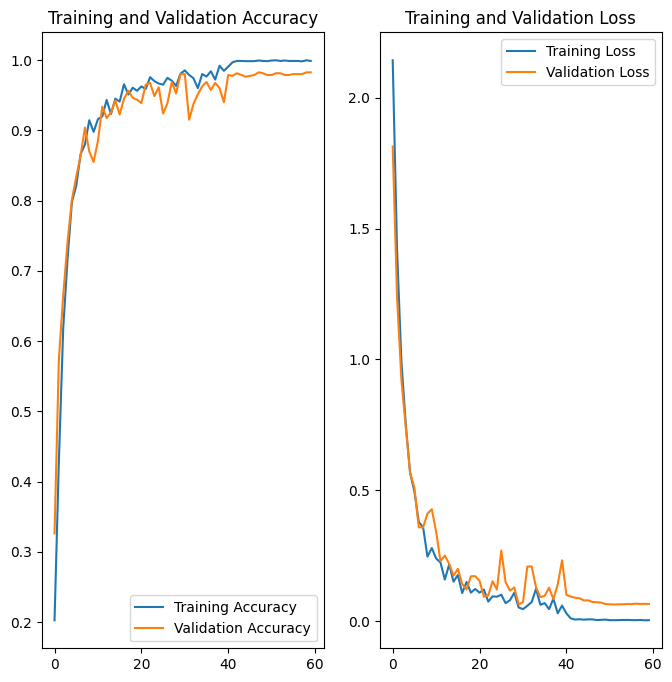

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing

In [18]:
def predict_mango_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [19]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "Test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 656 files belonging to 8 classes.


In [20]:
plt.figure(figsize=(25, 25))
for images, labels in test_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_mango_diseases(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [21]:
from keras.models import load_model
model.save('/content/drive/MyDrive/saved_models/model_mango.h5')